In [1]:
import h5py
import numpy as np
from matplotlib import pyplot as plt

#h5f = h5py.File('overlapping_chromosomes_examples.h5','r')
h5f = h5py.File('./overlapping-chromosomes/LowRes_13434_overlapping_pairs.h5','r')
pairs = h5f['dataset_1'][:]
h5f.close()
pairs.shape

(13434, 94, 93, 2)

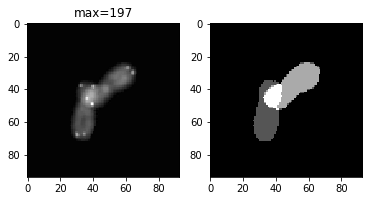

In [7]:
grey = pairs[1521,:,:,0]
mask = pairs[1521,:,:,1]
%matplotlib inline
plt.subplot(121)
plt.imshow(grey,cmap='gray')
plt.title('max='+str(grey.max()))
plt.subplot(122)
plt.imshow(mask,cmap='gray')


In [11]:
pairs[1,:,:,0].shape

(94, 93)

In [18]:
import scipy.misc as scipyMis 

resampledGrey=[]
resampledMask=[]
for i in range(pairs.shape[0]):
    resampledGrey += [scipyMis.imresize(pairs[i,:,:,0],[112,112],'nearest')]
    resampledMask += [scipyMis.imresize(pairs[i,:,:,1],[112,112],'nearest')]

In [46]:
np.array(resampledGrey).shape
np.max(resampledMask[0])
a=np.unique(np.array(resampledMask[0]/85).astype(int)).flatten()
print(a)

[0 1 2 3]


In [47]:
xtrain = np.array(resampledGrey)/255.0
ytrain = (np.array(resampledMask)/85).astype(int)

In [48]:
x_train=np.expand_dims(xtrain,axis=-1)
ytrain=np.reshape(ytrain,(13434,-1))
ytrain.shape

(13434, 12544)

In [49]:
from keras.models import Model, Sequential, load_model
from keras.layers import *
from keras.optimizers import *


inputs = Input((112, 112,1))
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

up6 = Concatenate(axis=-1)([UpSampling2D((2,2))(conv5), conv4])
conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

up7 = Concatenate(axis=-1)([UpSampling2D((2,2))(conv6), conv3])
conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

up8 = Concatenate(axis=-1)([UpSampling2D((2,2))(conv7), conv2])
conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

up9 = Concatenate(axis=-1)([UpSampling2D((2,2))(conv8), conv1])
conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

conv10 = Conv2D(4, (1, 1))(conv9)
conv11 = Reshape((-1, 4))(conv10)
conv12 = Activation('softmax')(conv11)

model = Model(input=[inputs], output=[conv12])
model.compile(optimizer=Adam(lr=1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

C:\Users\HuaSheng\AppData\Local\conda\conda\envs\tfkeras\lib\site-packages\ipykernel_launcher.py:46: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=[<tf.Tenso...)`


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_4 (InputLayer)             (None, 112, 112, 1)   0                                            
____________________________________________________________________________________________________
conv2d_40 (Conv2D)               (None, 112, 112, 32)  320         input_4[0][0]                    
____________________________________________________________________________________________________
conv2d_41 (Conv2D)               (None, 112, 112, 32)  9248        conv2d_40[0][0]                  
____________________________________________________________________________________________________
max_pooling2d_9 (MaxPooling2D)   (None, 56, 56, 32)    0           conv2d_41[0][0]                  
___________________________________________________________________________________________

In [45]:
model.fit(xtrain,ytrain)

ValueError: Error when checking input: expected input_2 to have 4 dimensions, but got array with shape (13434, 112, 112)